# Modelling of Text Summarization

Code adpated from 

https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]

## Import Modules

In [120]:
# Import modules and packages
import nltk
import string
import numpy as np  
import pandas as pd 
import re           
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from keras import models
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [121]:
#!python attention_ut.py

In [122]:
from attention_ut import AttentionLayer  

In [123]:
#nltk.download()
#print(nltk.__version__)
#dir(nltk)
#!pip install attention

## Load Cleaned Data

In [187]:
# Load master table
df = pd.read_csv("data.csv")

# Review sentences and summary
for i in range(5):
    print("Text:",df['cleaned_text'][i])
    print("Summary:",df['cleaned_summary'][i])
    print("\n")

Text: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Text: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Text: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Text: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Text: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
S

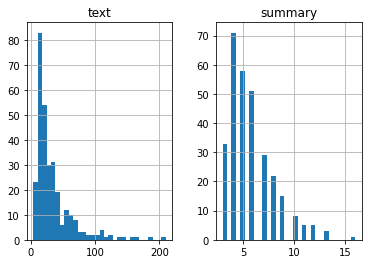

In [188]:
# Plot word count lengths of sentences

import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [189]:
# Set maximum text and summary lengths for the padding
max_len_text = 80
max_len_summary = 10
min_text_word_occurence = 4
min_summary_word_occurence = 3

In [190]:
# Train test split
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val = train_test_split(df['cleaned_text'], df['cleaned_summary'], 
                                                     test_size=0.2, random_state=37, shuffle=True) 

## Prepare Tokenizer

### Text Tokenizer

In [191]:
# Prepare a tokenizer for text on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

# convert text sequences into integer sequences
x_tr = x_tokenizer.texts_to_sequences(x_tr) 
x_val = x_tokenizer.texts_to_sequences(x_val)

# padding zero up to maximum length
x_tr = pad_sequences(x_tr, maxlen=max_len_text, padding='post') 
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')

# size of vocab
x_voc_size = len(x_tokenizer.word_index) +1
print(x_voc_size)

2519


### Summary Tokenizer 

In [192]:
# Prepare a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr = y_tokenizer.texts_to_sequences(y_tr) 
y_val = y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr = pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) +1
print(y_voc_size)

415


In [167]:
x_tr.shape

(240, 80)

In [168]:
y_tr.shape

(240, 10)

In [169]:
# Delete summaries that only have 'start' and 'end'
#start, end = y_tokenizer.word_index['start'], y_tokenizer.word_index['end']
#i = [i for i, v in enumerate(y_tr) if v[0] == start and v[1] == end]
#x_tr, y_tr = np.delete(x_tr, i, axis = 0), np.delete(y_tr, i, axis = 0)

## Pretrained embedding

In [131]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d.txt', encoding='utf8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400001 word vectors.


In [132]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((x_voc_size, 300))

for word, i in x_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Modelling

In [193]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text, ))
#enc_emb = Embedding(x_voc_size, latent_dim, weights=[embedding_matrix], input_length=100, trainable=False)(encoder_inputs) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])    

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      1259500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [194]:
# Specify loss function
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['acc'])

# Specify early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 1)

# Specify batch size
history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                    epochs=10, callbacks=[es], batch_size=128, validation_data=([x_val, y_val[:,:-1]], 
                                                                                y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
2/2 [==============================] - 28s 16s/step - loss: 5.8311 - acc: 0.1524 - val_loss: 3.7757 - val_acc: 0.5883
Epoch 2/10
2/2 [==============================] - 21s 13s/step - loss: 5.3485 - acc: 0.3635 - val_loss: 2.2567 - val_acc: 0.5883
Epoch 3/10
2/2 [==============================] - 21s 12s/step - loss: 2.9905 - acc: 0.5014 - val_loss: 2.1203 - val_acc: 0.5883
Epoch 4/10
2/2 [==============================] - 21s 12s/step - loss: 3.0890 - acc: 0.4687 - val_loss: 2.1425 - val_acc: 0.5883
Epoch 00004: early stopping


### Diagnostic plot

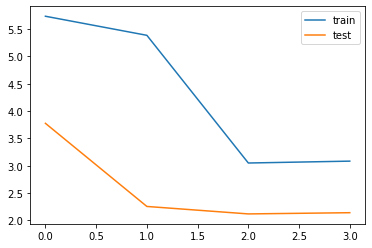

In [195]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [196]:
# Build dictionary to convert index to word for summary and text vocabulary
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

### Inference

Set up the inference for the encoder and decoder:

In [197]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))


# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the summary vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [198]:
# Define function to implement inference process 
def decode_sequence(input_seq):
    """
    Function:     To convert the vector of a text review into an abstracted review
    Inputs:       Text review in vector form. For this case, the vector has to be of length 100.
    Returns:      Abstracted Review
    """
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty summary sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the summary sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [199]:
# Define functions to convert an integer sequence to a word sequence for summary and text
def seq2summary(input_seq):
    """
    Function:     To convert a sequence into a summary
    Inputs:       A vector of 10, based on review summaries
    Returns:      A worded summary
    """
    newString = ''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString += reverse_target_word_index[i] + ' '
    return newString

def seq2text(input_seq):
    """
    Function:     To convert a sequence into a text review
    Inputs:       A vector of 100, based on reviews
    Returns:      A worded review
    """
    newString = ''
    for i in input_seq:
        if(i!=0):
            newString += reverse_source_word_index[i]+' '
    return newString

In [200]:
x_val[0].shape

(80,)

In [201]:
decode_sequence(np.array(x_val[0]).reshape(1,80))

KeyError: 0

In [204]:
for i in range(len(x_val)):
    print("Text:", seq2text(x_val[i]))
    print("Original summary:", seq2summary(y_val[i]))
    print("Predicted summary:", decode_sequence(x_val[i].reshape(1, max_len_text)))
    print("\n")

Text: deal awesome arrived halloween enough trick love quality product much less expensive local store candy 
Original summary: awesome deal 


KeyError: 0